# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


# Vanilla Autoencoder (3 балла)

## Prepare the data


In [0]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from get_dataset_correct import fetch_dataset
data_LFW, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done
45 45


In [0]:
IMAGE_H = data_LFW.shape[1]
IMAGE_W = data_LFW.shape[2]
# у нас цветные изображения
N_CHANNELS_1 = 3

TRAIN_SIZE = 10000
VAL_SIZE = data_LFW.shape[0] - TRAIN_SIZE


Разбейте выборку картинок на train и val и приведите значения элементов в интервал [0, 1] типа float

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data_LFW, attrs, test_size=VAL_SIZE/(VAL_SIZE + TRAIN_SIZE),
                                                  random_state=42)#<тут Ваш код>

X_train = X_train/255.0
X_val = X_val/255.0

Напишем вспомогательную функцию, которая будет выводить n_row $\cdot$ n_col первых картинок в массиве images:

In [0]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())
        except:
            pass

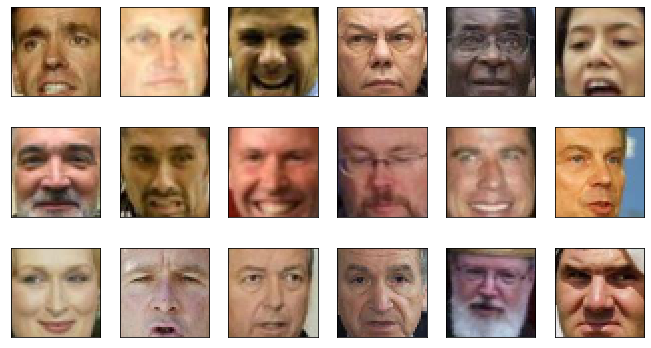

In [0]:
plot_gallery(X_train, IMAGE_H, IMAGE_W)

Осталось привести картинки к тензорам из PyTorch, чтобы можно было потом скармливать их автоэнкодеру: 

In [0]:
X_train = torch.FloatTensor(X_train)#<тут Ваш код>
X_val = torch.FloatTensor(X_val)

batch_size = 128
train_loader = data_utils.DataLoader(X_train, batch_size=batch_size, shuffle=True)
val_loader = data_utils.DataLoader(X_val, batch_size=batch_size, shuffle=False)

## Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:
<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

In [0]:
inp_size_1 = X_train.shape[1]
hid_size_1= 250
dimZ_1 = 100

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [0]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        #<определите архитектуры encoder и decoder>
        super().__init__()
        # encoder
        self.lin1 = nn.Linear(inp_size_1*inp_size_1*N_CHANNELS_1, hid_size_1)
        self.lin21 = nn.Linear(hid_size_1, dimZ_1)
        self.lin22 = nn.Linear(hid_size_1, dimZ_1) 
        # decoder
        self.lin3 = nn.Linear(dimZ_1, hid_size_1)
        self.lin4 = nn.Linear(hid_size_1, inp_size_1*inp_size_1*N_CHANNELS_1)

    def encoder(self, x):
        x1 = F.relu(self.lin1(x))
        return self.lin21(x1), self.lin22(x1)

    def reparameterize(self, mu, logvar):
        if self.training:
            # На этапе обучения добавляем шум к латентному пространству
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decoder(self, z):
        x = F.relu(self.lin3(z))
        return torch.sigmoid(self.lin4(x)).view(-1, inp_size_1, inp_size_1, N_CHANNELS_1)

    def forward(self, x):
        #<реализуйте forward проход автоэнкодера
        #в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code) 
        #и полученная реконструкция изображения (reconstruction)>
        mu, logvar = self.encoder(x.view(-1, inp_size_1*inp_size_1*N_CHANNELS_1))
        z = self.reparameterize(mu, logvar)
        latent_code = z
        reconstruction = self.decoder(z)
        return reconstruction, latent_code


In [0]:
criterion = nn.MSELoss()#<MSE LOSS>

autoencoder = Autoencoder()

optimizer = optim.Adam(autoencoder.parameters(), 1e-3)#<Ваш любимый оптимизатор>

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

Подсказка: если x_val -- каринка, а reconstruction -- ее реконструкция автоэнкодером, то красиво вывести эту каритинку и ее реконструкцию можно с помощью функции plot_gallery вот так:

*plot_gallery([x_val, reconstruction], image_h, image_w, n_row=1, n_col=2)*

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [0]:
#<тут Ваш код тренировки автоэнкодера>
train_losses_1 = []
val_losses_1 = []
num_epoch_1 = 30
batch_size = 128

for epoch in range(num_epoch_1):

    total_train_loss_1 = 0
    for item in train_loader:
        # forward
        reconstruction_1, latent_code_1 = autoencoder(item)

        # loss
        train_loss_1 = criterion(reconstruction_1,item)
        total_train_loss_1 += train_loss_1/batch_size

        optimizer.zero_grad()
        train_loss_1.backward()
        optimizer.step()

    train_losses_1.append(total_train_loss_1.item())

    total_val_loss_1 = 0
    for item in val_loader:
        autoencoder.eval()
        # forward
        reconstruction_1, latent_code = autoencoder(item)

        # loss
        val_loss_1 = criterion(reconstruction_1,item)
        total_val_loss_1 += val_loss_1/batch_size

    val_losses_1.append(total_val_loss_1.item())

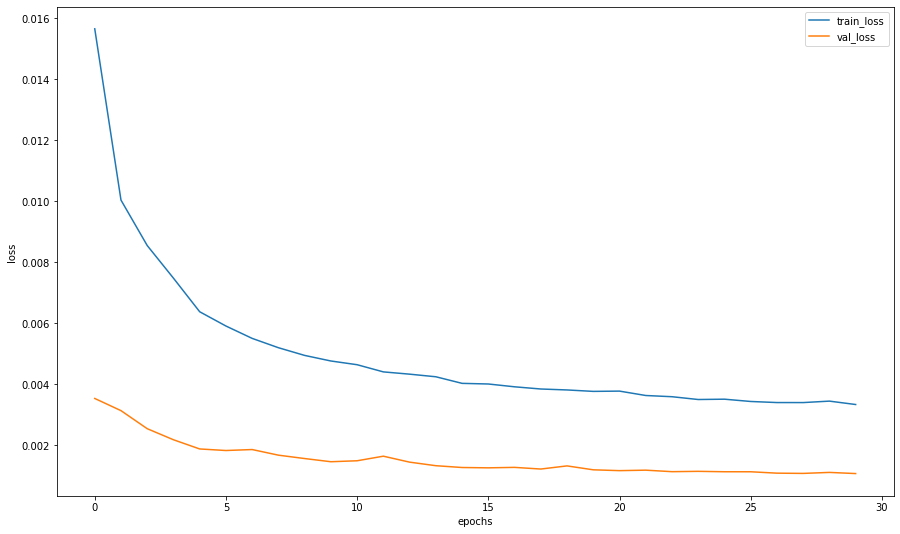

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(train_losses_1, label="train_loss")
plt.plot(val_losses_1, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [0]:
train_losses_1[-1]

0.0033402065746486187

In [0]:
val_losses_1[-1]

0.0010780706070363522

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


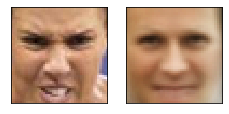

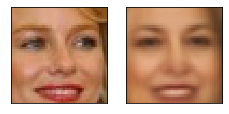

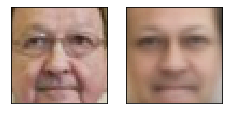

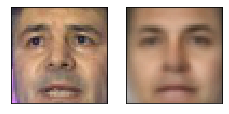

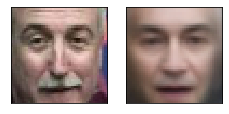

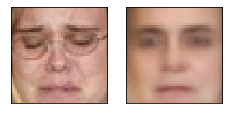

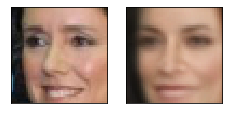

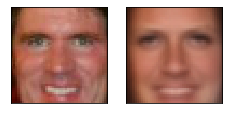

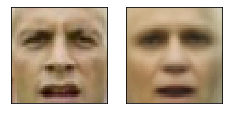

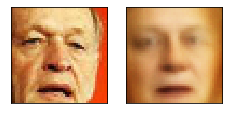

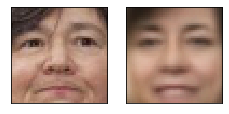

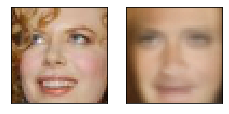

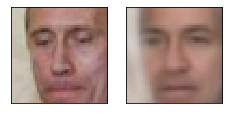

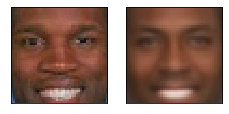

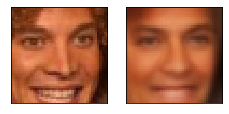

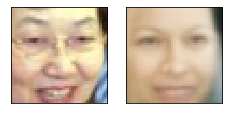

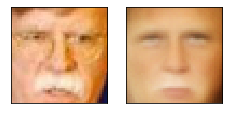

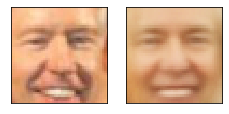

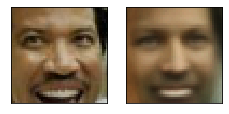

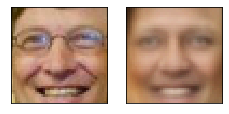

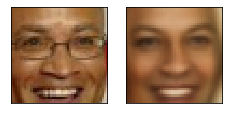

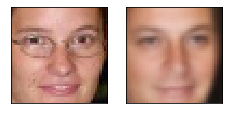

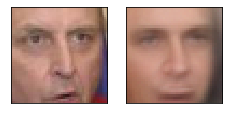

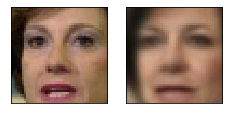

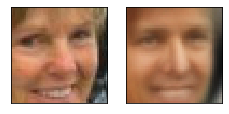

In [0]:
#< тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
# Выведим их по 2 штуки друг за другом
for item in val_loader:
    autoencoder.eval()
    reconstruction_1, latent_code_1 = autoencoder(item)
    plot_gallery([item[-1], reconstruction_1.detach()[-1]],  IMAGE_H, IMAGE_W, n_row=1, n_col=2)

Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### If that doesn't work
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как лаьентные векторы реальных фоток. Так что ридется рандом подогнать.

In [0]:
# Найдем распределение латентных векторов реальных фоток по тренировочным данным
autoencoder.eval()
reconstruction_1, latent_code_1 = autoencoder(X_train)

In [0]:
mu_1 = latent_code_1.mean(dim=0)
std_1 = latent_code_1.std(dim=0)

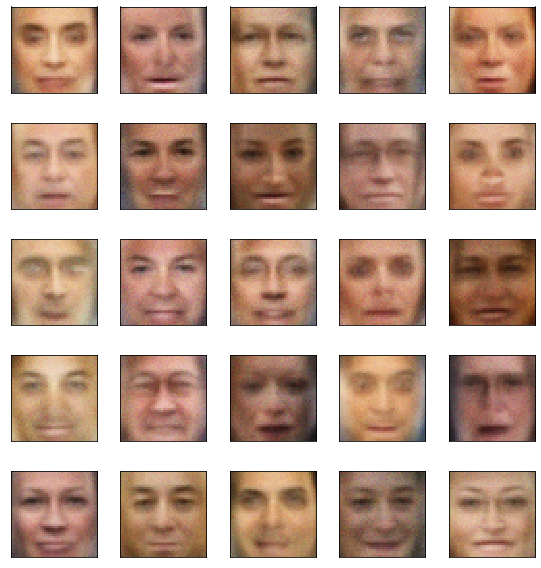

In [0]:
# сгенерируем 25 рандомных векторов размера latent_space
z = std_1.detach().numpy() * np.random.randn(25, dimZ_1) + mu_1.detach().numpy()
output = autoencoder.decoder(torch.FloatTensor(z)) #<скормите z декодеру>
plot_gallery(output.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=5, n_col=5)

## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [0]:
###

Сначала я выбрал ~ 20 людей с улыбками и столько же без. В итоге, среди 20 людей с улыбками было 19 женщин, и только 1 мужчина. Среди 20 грустных людей - все мужчины. Таким образом, у меня получилось, что грустный человек не только становится улыбающимся, но и если он был мужчиной, то становится женщиной.
После этого, я решил выбрать примерно поровну мужчин и женщин в каждой категории (улыбающихся и грустных).

In [0]:
# Найдем счастливых мужчин
attrs[(attrs.Smiling > 2.4) & (attrs.Male > 0)]

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
534,0.605531,-1.37039,0.187643,-0.628719,-2.26722,-1.92806,0.590946,-0.377895,-0.718683,-0.645937,-1.00749,-0.893016,-0.622051,1.81368,-1.80489,-0.570194,-0.413743,2.53496,-2.39372,-0.718174,-0.604053,-1.03733,-0.305095,0.835678,1.22803,0.506192,0.0742,-0.794184,0.733063,0.395938,-0.166189,-1.70328,-0.377976,0.215276,0.668688,-0.199108,0.387966,0.664208,1.27235,0.217559,-0.305806,-1.7333,0.520756,-0.649328,-1.40568,-0.0732645,0.211015,0.163472,-0.0909827,-0.155042,-0.0340929,-0.478919,-1.12449,1.44739,0.541776,0.764235,-0.17655,-0.677228,-0.540317,0.763452,-0.518985,-1.92968,-0.435731,-1.415,1.36291,1.83546,-0.655037,-1.94852,1.20045,1.90557,-0.542813,-0.561924,0.194242
1359,0.486669,-1.8897,1.31055,-0.48526,-1.18827,-1.61469,0.224698,-0.385233,-0.695897,-1.23629,-0.187664,-1.56401,-0.712955,1.06395,-1.42912,-0.839509,-1.18349,2.67718,-2.67291,0.0185866,-0.138868,-1.15782,-0.186681,0.94912,1.12852,0.501799,0.149331,-0.668525,0.653841,-0.753398,-0.759974,1.98948,-0.852004,-0.392878,0.151307,-0.749973,0.612651,0.902361,-0.0185984,0.0513037,-0.734081,-1.92233,0.264307,-0.00971003,-2.02491,0.995665,-1.15232,0.412481,0.639758,-1.24836,-0.2619,-0.23155,-0.423641,3.85374,0.212072,-0.301852,-0.834941,-0.770425,-0.268113,0.211928,-0.57733,2.92967,-0.750406,-0.561331,-0.176155,1.4022,-0.283779,0.57933,1.30836,1.06129,-0.398895,-0.311059,0.486818
1605,0.464977,-0.228893,0.0541642,-2.7349,-1.78743,-0.734932,1.7598,-0.70976,-1.71643,-0.756874,-1.34316,2.42069,-1.94244,1.42914,-0.63133,-1.69839,-1.48256,2.58621,-2.39899,-0.655515,-0.812245,-1.89175,0.441163,0.252324,-0.733861,0.932824,-1.56622,-0.278051,-1.69769,0.797584,0.533021,-3.44378,0.275956,-0.523313,1.81659,-1.57609,2.40416,0.851186,0.306135,0.238058,-0.779997,-1.59708,1.75769,-1.53748,-2.31802,1.22519,-0.80109,0.4276,-0.624102,-1.35224,-0.447399,-0.759006,0.321639,3.48821,-0.786762,-0.187518,-0.682399,-1.20532,-1.47401,0.0365172,-0.635643,-0.951577,-0.090078,0.831229,-0.348167,0.374276,-1.15498,-1.16772,0.396738,0.706832,-0.884408,-0.305028,0.183632
3249,0.839734,-1.84084,0.499152,-0.781519,-1.82939,-1.17724,-0.684455,-0.203648,-0.600665,-0.283996,-0.974544,1.33707,-0.217935,1.32204,-0.932051,-1.03999,-0.659145,2.47944,-2.51231,0.435267,-0.950986,-0.261946,-1.06949,0.709222,1.08961,0.121376,-0.829282,0.174566,0.526183,0.0753795,-0.183389,0.449584,-0.509535,-0.729581,0.292669,-0.235759,1.38573,0.693026,0.327719,0.19713,0.134267,-1.75081,0.485538,-0.243355,-1.99788,0.559256,-0.312994,0.248256,0.260213,-0.996151,-0.61638,0.0558629,-0.201375,1.1033,-0.0305719,0.132225,-0.84008,-0.831087,-1.14289,1.19675,-0.783823,-1.969,-0.798743,-0.201379,-0.544674,1.73754,-0.863347,-2.31276,0.66412,1.37889,-1.27332,0.61325,-0.162408
9513,0.190921,0.847019,-0.896625,-1.70191,-1.72292,-1.66259,-0.182252,-0.763565,-0.337385,-0.341068,-1.39224,-0.810489,-1.02887,0.742588,1.00118,-1.85726,-0.962033,2.4437,-2.49328,0.67565,-0.462797,-0.186268,-0.536768,0.379747,0.686058,-0.34168,-0.813385,0.649056,0.435307,-0.876226,-0.483275,-0.530174,-0.85175,-0.796791,0.64238,-0.744655,1.18274,1.0973,1.91855,-0.901608,0.190084,-2.05486,0.80345,-0.754366,-2.06152,1.10

In [0]:
# Найдем счастливых женщин
attrs[(attrs.Smiling > 2.7) & (attrs.Male < 0)]

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
1045,-1.94055,-0.583674,0.237089,-2.56292,-1.91296,-0.656768,0.616543,-0.910771,-1.3329,-0.57988,-0.581727,-0.26846,-1.26585,2.55513,-1.96223,-1.87624,-1.5295,2.73704,-2.89854,0.266929,-0.175145,-0.521655,-0.961018,0.224989,0.31239,-0.222456,-0.0746435,-0.0975872,-1.64035,-1.57104,-1.40973,2.04199,-1.12377,-0.895779,-1.07936,1.55141,2.0278,0.206797,0.175657,-0.0680085,0.0763686,-1.96034,1.83222,-1.43811,-1.68468,2.06273,-1.55698,0.670172,-0.221476,-0.447758,-0.108404,-0.888299,-0.0914552,3.90812,0.840808,0.163153,0.516793,-1.38166,-1.96574,0.843526,0.815251,-0.636428,-0.808135,0.436579,-2.55325,1.69059,0.736134,-3.12556,1.30952,0.995389,0.644106,-1.58417,0.964526
1816,-0.626934,-0.472967,0.3272,-1.67819,-1.83184,-0.932025,0.605919,-0.859935,-0.932806,-1.85141,0.353286,-1.16307,-1.70895,2.00763,-1.43021,-1.49077,-1.05293,2.79183,-2.73526,-1.48354,-0.767803,-1.00836,-0.840239,0.656511,1.12907,-0.348206,-0.307372,0.459675,-0.255796,-0.359679,-0.95307,0.600233,-0.455375,-0.327673,-0.864052,0.4511,0.727996,1.36088,0.659635,0.0898241,-0.0627581,-1.71902,0.719011,-0.52689,-1.39839,1.36648,-0.701763,0.406105,-0.480482,-1.12158,-0.495378,-0.803245,-0.5548,3.93475,0.407317,-0.0392856,0.152979,-1.36114,-0.960579,0.630621,-0.0922147,1.01838,-0.854028,0.144034,-1.38578,2.40934,0.886918,-0.380016,1.53834,0.980102,-0.117775,-0.335121,0.72465
4681,-0.79572,-0.244533,-0.46258,-2.42803,-1.70112,-1.45652,0.430202,0.201042,-1.70241,0.432704,-0.899651,-0.0198914,-0.41501,2.30348,-1.38351,-2.04718,-1.61657,2.71721,-2.83653,0.366286,-0.15881,-1.2461,-0.800225,0.262579,-0.132793,-0.532809,-0.947167,1.42356,-1.50753,-1.43036,-1.14648,1.13327,-1.18488,-1.39628,-1.66377,1.10241,2.02523,0.778018,0.330044,-0.419015,-0.663171,-1.50459,1.40797,-1.45474,-1.69307,1.50266,-1.09684,0.658805,-0.793204,-0.856684,-0.81446,-1.04767,0.0678739,5.56234,1.55004,0.205807,0.641399,-1.27447,-2.34662,-0.0589892,-0.688245,-1.36293,-0.89063,-1.77413,-1.84905,1.72626,0.159129,-0.434353,0.964951,2.14793,0.551308,-1.8058,0.308181
5624,-2.65704,-2.05056,1.55103,-1.53539,-2.00655,-1.39812,0.814239,0.0773967,-1.9286,-1.75531,0.0678493,-0.434644,-2.48953,2.24792,-2.13569,-1.25219,-1.66715,2.74382,-2.86039,-0.326588,-0.785881,-0.460734,-0.302607,-0.0676116,-0.195193,0.067433,0.766723,-0.725601,-2.04021,-0.763162,-1.33677,-0.0328493,-0.0844537,-0.95866,-2.06931,1.07898,-0.815724,1.58454,-0.925236,0.828779,-0.458281,-1.72724,-0.174624,-0.0870424,-1.72893,2.2549,-1.42901,0.380103,-0.396362,-1.71972,-0.137499,-0.710379,-0.370534,1.22334,1.26218,0.595047,1.05689,-0.997421,-1.31436,-0.253913,1.36712,-1.68474,0.564668,2.22016,-2.13596,2.38474,2.68792,-3.62641,1.81234,-0.576399,1.15357,-0.975989,0.637409
6139,-1.44733,-1.05412,-0.369352,-0.0375968,-1.28051,-0.394689,1.16752,-1.06695,-1.71632,-1.30338,-0.111778,-2.74321,-0.533919,0.404375,-1.18136,-0.813064,-1.83591,2.71663,-2.7284,-1.50473,0.132194,-1.5424,-0.191583,1.78297,-0.0283584,-1.12704,1.10944,0.219169,-1.06853,-1.05882,-0.707883,0.922176,-0.472778,-0.876117,-0.646831,1.51442,0.678412,0.43982,0.00313198,0.463959,-0.919235,-1.3918,2.13613,-2.12098,-1.44886,2.46875,-1.38053,0.28596

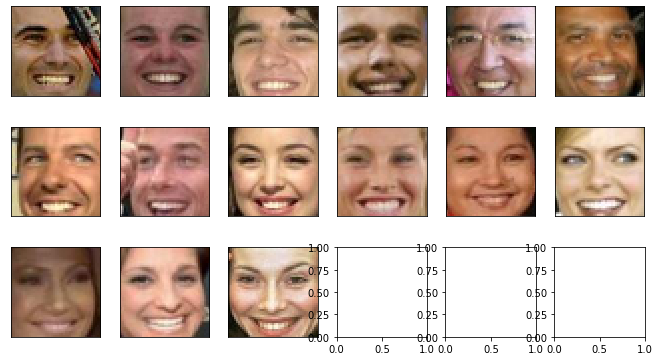

In [0]:
data_happy = np.array([data_LFW[534], data_LFW[1359], data_LFW[1605], data_LFW[3249], data_LFW[9513], data_LFW[10457], data_LFW[11290], data_LFW[11658], 
              data_LFW[1045], data_LFW[1816], data_LFW[4681], data_LFW[5624], data_LFW[6139], data_LFW[8643], data_LFW[13034]])
plot_gallery(data_happy, IMAGE_H, IMAGE_W)
# 8 мужчин, 7 женщин


In [0]:
# Найдем грустных мужчин
attrs[(attrs.Smiling < -2.5) & (attrs.Male > 0)]

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
471,1.20998,-1.7902,0.688839,-1.63853,-1.69941,0.436127,-0.317447,-0.473203,-1.66933,-0.499657,-0.217914,-1.69178,-1.53157,0.922852,-1.71459,-1.17148,-0.919182,-2.55587,2.58319,-0.260078,-0.303694,-0.192939,-1.60895,0.489459,0.581695,0.837591,-0.628748,-1.49115,-1.45341,-0.717692,-0.189708,1.20516,-0.723049,-1.20288,-0.0551295,-2.3776,0.314206,1.56678,-1.16289,1.43465,0.634088,-1.24792,0.364054,-0.433472,0.42486,1.10229,-0.856128,0.194722,-0.255411,-0.822552,0.0430652,-0.422485,-0.20521,2.85569,-0.804842,-0.251429,0.123659,-0.788245,-1.92076,-1.07557,-0.439017,-1.96197,-1.70318,0.217472,-0.728136,-1.69644,-1.40167,-3.19147,-2.24888,0.525155,-1.06538,-0.596269,-1.08004
1234,0.954913,-0.983356,2.067,-2.49582,-1.52877,-0.510492,-1.02894,-0.17107,-1.04501,-1.00008,-0.260434,0.512037,-1.62603,1.15367,-0.309216,-2.19766,-0.350291,-2.66448,2.68302,0.612659,-1.48806,-1.30216,-0.448976,1.45569,-0.280929,0.573047,-0.352814,-0.286481,0.0846007,-0.811595,-0.415044,0.110104,-0.347048,-0.40867,-1.31037,0.272894,-0.693458,2.14676,-1.65071,1.69862,-0.120361,0.286254,-0.28992,-0.718144,1.06015,0.134266,-0.0711387,0.128932,0.156428,-0.211038,0.18746,-0.586896,-0.2673,4.27009,0.80884,-0.486308,-0.864898,-1.94131,-0.8908,-0.459661,-1.01371,0.701034,-1.60782,-0.337012,0.729144,-1.76426,-1.49386,0.922482,-1.47265,-1.25914,-0.776729,-0.104821,-1.22919
1432,1.37012,-2.64539,2.89034,-2.37607,-2.173,-1.66024,-0.755473,0.134192,-1.05973,-0.761769,-0.394673,-0.695146,-1.12915,1.29946,-1.39018,-1.51204,-0.276943,-2.51664,2.44526,-0.473188,-0.618197,-1.27746,-0.503136,-0.00797005,0.192917,-0.0754028,-1.09051,-0.918414,-0.0544576,-1.68995,0.104823,1.81539,-1.56058,-1.35708,-0.342725,-1.58687,0.0498349,1.80144,0.372092,1.31005,-0.271751,0.4379,-0.492099,-0.687327,1.26419,0.0359693,0.548677,-0.215916,-0.603025,-0.955081,0.581307,-0.150901,-1.00019,4.07787,0.376767,-0.08018,-0.519904,-2.10421,-1.47948,-0.261148,-1.046,-1.18751,-0.650198,-0.308652,1.10607,-0.919482,-1.55156,-0.838313,-1.95223,-1.57051,-0.428118,0.251507,-0.85552
1654,2.82584,-1.89211,1.25379,-1.63232,-1.88545,-0.667522,-1.40402,0.125236,-0.302133,-1.60572,-0.523892,0.652727,-0.874948,1.21634,-0.232425,-1.70612,-0.164706,-2.58913,2.4894,0.0695201,-0.566518,-0.69945,-0.131082,1.43168,-1.55704,1.38064,0.1369,-1.33457,0.290121,0.204714,0.438158,0.211715,-0.184229,-0.148565,0.548104,-2.56875,-0.368791,1.27462,0.760539,0.926775,-0.397401,1.34307,-1.14618,-1.15003,1.19999,-0.370316,0.420456,-0.144502,-0.3336,-0.521184,0.558019,-0.11246,-0.930601,3.01905,0.172612,0.444669,-0.579123,-0.649225,-0.722425,0.2655,-1.49781,-0.652167,-0.219002,-0.961814,1.12556,-0.898104,-1.92188,-0.933705,-1.57267,-1.59494,-1.39566,0.269789,-0.836642
7065,1.65926,-0.886879,0.79353,-1.15237,-1.30286,-0.241565,0.380882,-0.723661,-0.7521,-0.99002,-0.499866,-1.09243,-0.981157,0.744052,-1.73844,-0.558358,-0.77448,-2.63077,2.58482,-0.739837,-0.695199,-0.142387,-1.21946,1.36132,0.476235,0.145654,0.862377,-1.14007,-0.484857,0.0633071,-0.125703,-1.94324,-0.471364,0.516583,-0.216452,-2.51983,0.377165,1.19426,-0.680197,0.609426,0.386815,0.364327,-0.532347,-0.962451,1.22833,0.651794,

In [0]:
# Найдем грустных женщин
attrs[(attrs.Smiling < -2.2) & (attrs.Male < -0.1)]

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
295,-1.64897,-1.63739,0.515963,-2.45972,-2.02465,-0.0493624,0.708016,-0.860983,-1.30761,-0.269515,-1.05719,0.584532,-1.61728,2.12093,-1.97709,-1.14204,-1.74352,-2.24637,2.39236,-0.650295,-0.657306,0.0559008,-1.6252,0.391251,-0.208813,-0.131802,0.68104,-0.176891,-1.0319,-1.57043,-0.134082,1.80051,-0.58196,-1.214,-0.0380303,-1.12747,0.536926,0.196452,-0.30368,0.596134,0.190911,0.49165,-0.787735,-0.976136,1.18119,1.44524,-1.39096,0.286067,-1.21504,-1.55678,0.827511,-0.672638,-0.583708,5.73729,-0.0692751,-0.128082,-0.34431,-0.731359,-1.61304,-0.190396,0.0414998,-0.264936,-1.54556,-0.648684,-1.22689,-1.2471,-0.0796919,-2.84567,-0.704462,1.27119,-0.496129,-0.131119,-0.124794
508,-0.388401,-1.71975,-0.0400924,-3.00638,-0.319824,-0.137616,-0.735406,-0.981275,-1.14915,-0.135051,-1.14624,0.48935,-1.58376,0.72311,-1.76756,-1.24472,-1.05221,-2.34544,2.39458,-0.278347,-0.874512,-0.205812,-1.3986,0.691452,0.945963,0.578075,-0.986971,-0.493684,-2.87446,-1.9514,-0.661129,-0.66408,-0.776452,-1.11916,-0.690353,-0.287046,-0.851483,1.16819,-1.08381,0.415299,0.381828,-0.106319,-0.211261,-1.27852,1.18548,1.0555,-0.650837,0.415377,0.0738797,-0.719355,-1.35502,-0.68077,1.01347,0.702798,0.0484936,-0.287091,-0.26465,-0.733186,-0.9717,-0.384474,-1.09126,-1.99236,-1.56563,3.23957,-0.957177,-1.33747,-0.611631,-4.05764,-1.12672,-1.20112,-0.327739,-0.0982741,-0.152462
2799,-0.513371,-1.63087,0.919909,-1.63095,-2.89286,-0.516286,0.386343,-0.337027,-1.24973,-1.79307,0.392288,-0.713067,-1.80472,2.34016,-1.37405,-1.56542,-1.59425,-2.22842,2.26325,-0.626834,-0.0944222,-0.835795,-1.47977,1.45284,0.597667,-0.574061,-0.562043,-0.816262,-2.19456,-0.192238,-0.397329,-0.591221,-0.589917,-0.403407,-0.484696,-0.867967,0.15932,1.17432,-0.706466,0.840322,-0.503311,0.915729,0.000912872,-0.980927,1.20283,1.55042,-1.43049,0.251554,-0.743658,-0.0188803,0.351504,-0.9956,-0.250611,1.53744,-1.13531,-0.229198,-0.465654,-1.348,-1.46739,0.00658809,-0.153726,-2.66909,-1.15249,2.06302,-1.14511,-0.865299,-0.605503,-5.34758,-0.617339,-0.300045,0.113825,0.192015,-0.233617
5458,-0.188162,-0.647783,0.715927,-2.76761,-2.21039,-0.379383,-0.167709,-0.813777,-1.36702,-1.80845,0.505613,-0.611531,-1.47177,2.08903,-1.81059,-1.53889,-1.3664,-2.63975,2.71643,1.09554,-0.862419,-0.943296,-1.70693,1.19373,0.43543,0.375474,-0.013277,0.0444094,-1.31191,-0.477799,-0.347753,-0.155622,-0.304943,-0.787855,-0.695325,-0.745607,1.34598,1.47785,-0.651079,0.558446,0.181205,-0.503759,-0.0874418,-1.10772,1.5582,1.08047,-0.860124,0.252413,0.0638529,-1.06328,-0.108704,-0.785428,-0.0041451,2.68409,0.4467,-0.795015,-0.441005,-1.66714,-1.15455,-0.139051,-1.09452,0.631594,-1.04457,0.842378,-0.674481,-1.10116,-1.05383,-1.65771,-1.63174,0.219495,-1.00742,0.464435,-0.972584
8708,-0.146835,-1.74718,1.62046,-1.77056,-1.51124,-0.0919076,-0.867127,-0.715012,-0.516883,-1.5863,-0.102613,0.0401746,-1.64745,1.30458,-1.01196,-1.25713,-1.89436,-2.3908,2.28609,-0.402374,-0.0853206,-0.349427,-1.03699,0.267317,-0.513832,0.371308,-0.228996,-0.892339,-1.39577,1.14362,-0.814683,-2.20617,-0.182131,-0.0592429,-0.7668,0.111431,0.925295,-0.462005,-1.01284,0.118697,-0.326025,0.790091,-0.85

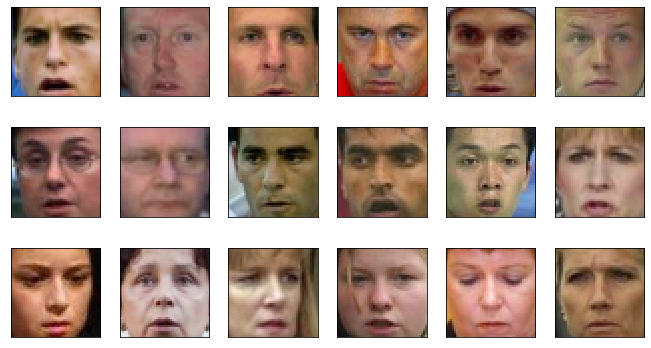

In [0]:
data_sad = np.array([data_LFW[471], data_LFW[1234], data_LFW[1432], data_LFW[1654], data_LFW[7065], data_LFW[7506], data_LFW[8410], data_LFW[8596], 
                     data_LFW[10097], data_LFW[11571], data_LFW[11912], data_LFW[12688], data_LFW[295], data_LFW[508], data_LFW[2799], 
                     data_LFW[5458], data_LFW[8708], data_LFW[9339]])
plot_gallery(data_sad, IMAGE_H, IMAGE_W)
# 11 мужчин, 7 женщин

In [0]:
#<а вот тут все это надо запрогать, да>
reconstruction_happy, latent_code_happy = autoencoder(torch.FloatTensor(data_happy/255.0))
reconstruction_sad, latent_code_sad = autoencoder(torch.FloatTensor(data_sad/255.0))

In [0]:
# Находим "вектор улыбки"
smile_vector = latent_code_happy.mean(axis = 0) - latent_code_sad.mean(axis = 0)

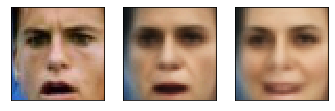

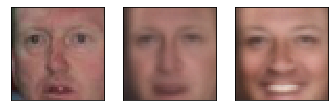

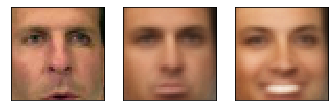

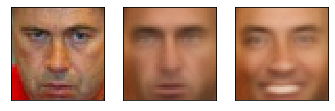

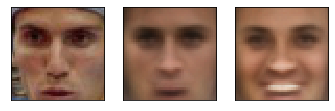

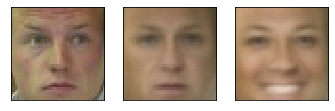

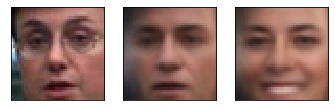

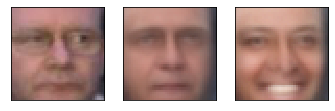

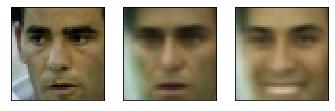

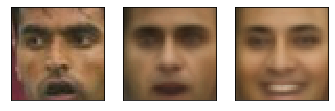

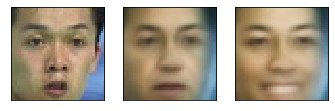

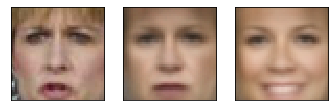

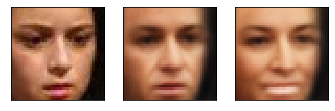

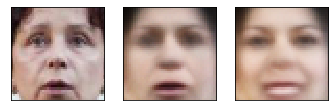

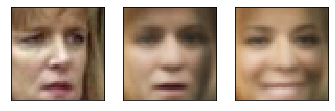

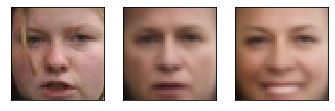

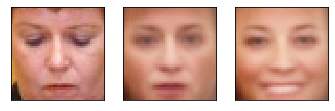

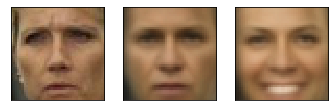

In [0]:
# Делаем произвольного грустного человека счастливым
for i in range(len(data_sad)):
    output_real = autoencoder.decoder(latent_code_sad[i])
    output_smiled = autoencoder.decoder(latent_code_sad[i] + smile_vector)
    plot_gallery([data_sad[i], output_real.data.cpu().numpy(), output_smiled.data.cpu().numpy()], IMAGE_H, IMAGE_W, n_row=1, n_col=3)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии)

# Conditional Autoencoder (3 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет

Как вы уже догадались, здесь мы будем использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/)

Если он вам очень не нравится, можете загуглить любой другой, в котором будет четкое разделение картинок по классам.

In [0]:
#<тут надо обработать датасет, построить и обучить Conditional AE (код обычного AE прекрасно берется за основу)>

In [0]:
import torch
import torchvision
from torchvision import transforms

In [3]:
# Загрузим датасет
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = tuple(str(i) for i in range(10))

0it [00:00, ?it/s]

9920512it [00:01, 9522827.67it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 142459.95it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 2330469.49it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 54231.52it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
inp_size = 28
hid_size_1 = 550
hid_size_3 = 450
hid_size_4 = 350
hid_size_2 = 250
dimZ = 100
N_CHANNELS = 1

In [0]:
def one_hot_encoding(y):
    a = torch.zeros(y.numpy().shape[0], 10)

    for i in range(y.numpy().shape[0]):
        a[i, y[i].numpy()] = 1
    
    return a

In [0]:
# Будем конкатенировать информацию о классе на каждом слое, по сравнению с предыдущим пунктом сеть глубже
class Conditional_Autoencoder(nn.Module):
    def __init__(self):
        #<определите архитектуры encoder и decoder>
        super().__init__()
        # encoder
        self.lin1 = nn.Linear(inp_size*inp_size*N_CHANNELS + 10, hid_size_1)
        self.lin5 = nn.Linear(hid_size_1 + 10, hid_size_3)
        self.lin7 = nn.Linear(hid_size_3 + 10, hid_size_4)
        self.lin9 = nn.Linear(hid_size_4 + 10, hid_size_2)
        self.lin21 = nn.Linear(hid_size_2, dimZ)
        self.lin22 = nn.Linear(hid_size_2, dimZ) 
        # decoder
        self.lin3 = nn.Linear(dimZ + 10, hid_size_2)
        self.lin10 = nn.Linear(hid_size_2 + 10, hid_size_4)
        self.lin8 = nn.Linear(hid_size_4 + 10, hid_size_3)
        self.lin6 = nn.Linear(hid_size_3 + 10, hid_size_1)
        self.lin4 = nn.Linear(hid_size_1 + 10, inp_size*inp_size*N_CHANNELS + 10)

    def encoder(self, x, y):
        x1 = F.relu(self.lin1(torch.cat([x, one_hot_encoding(y).view(-1,10)], dim = 1)))
        x2 = F.relu(self.lin5(torch.cat([x1, one_hot_encoding(y).view(-1,10)], dim = 1)))
        x3 = F.relu(self.lin7(torch.cat([x2, one_hot_encoding(y).view(-1,10)], dim = 1)))
        x4 = F.relu(self.lin9(torch.cat([x3, one_hot_encoding(y).view(-1,10)], dim = 1)))
        return self.lin21(x4), self.lin22(x4)

    def reparameterize(self, mu, logvar):
        if self.training:
            # На этапе обучения добавляем шум к латентному пространству
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decoder(self, z, y):
        x = F.relu(self.lin3(torch.cat([z, one_hot_encoding(y).view(-1,10)], dim = 1)))
        x1 = F.relu(self.lin10(torch.cat([x, one_hot_encoding(y).view(-1,10)], dim = 1)))
        x2 = F.relu(self.lin8(torch.cat([x1, one_hot_encoding(y).view(-1,10)], dim = 1)))
        x3 = F.relu(self.lin6(torch.cat([x2, one_hot_encoding(y).view(-1,10)], dim = 1)))
        return torch.sigmoid(self.lin4(torch.cat([x3, one_hot_encoding(y).view(-1,10)], dim = 1)))

    def forward(self, x, y):
        #<реализуйте forward проход автоэнкодера
        #в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code) 
        #и полученная реконструкция изображения (reconstruction)>

        mu, logvar = self.encoder(x.view(-1, inp_size*inp_size*N_CHANNELS), y)
        z = self.reparameterize(mu, logvar)
        latent_code = z

        reconstruction = self.decoder(z, y)
        return reconstruction, latent_code


In [0]:
criterion = nn.MSELoss()#<MSE LOSS>

autoencoder_conditional = Conditional_Autoencoder()

optimizer = optim.Adam(autoencoder_conditional.parameters(), 1e-3)#<Ваш любимый оптимизатор>

In [0]:
# Запустим процесс обучения
train_losses = []
val_losses = []
num_epoch = 20
batch_size = 128

for epoch in range(num_epoch):

    total_train_loss = 0
    for item in trainloader:
        # forward
        x, y = item
        reconstruction, latent_code = autoencoder_conditional(x.float(), y.float())

        # loss
        train_loss = criterion(reconstruction, torch.cat([x.view(-1,inp_size*inp_size*N_CHANNELS), one_hot_encoding(y).view(-1,10)], dim = 1))
        total_train_loss += train_loss/batch_size

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    train_losses.append(total_train_loss.item())

    total_val_loss = 0
    for item in testloader:
        x, y = item
        autoencoder_conditional.eval()
        # forward
        reconstruction, latent_code = autoencoder_conditional(x.float(), y.float())

        # loss
        val_loss = criterion(reconstruction, torch.cat([x.view(-1,inp_size*inp_size*N_CHANNELS), one_hot_encoding(y).view(-1,10)], dim = 1))
        total_val_loss += val_loss/batch_size

    val_losses.append(total_val_loss.item())

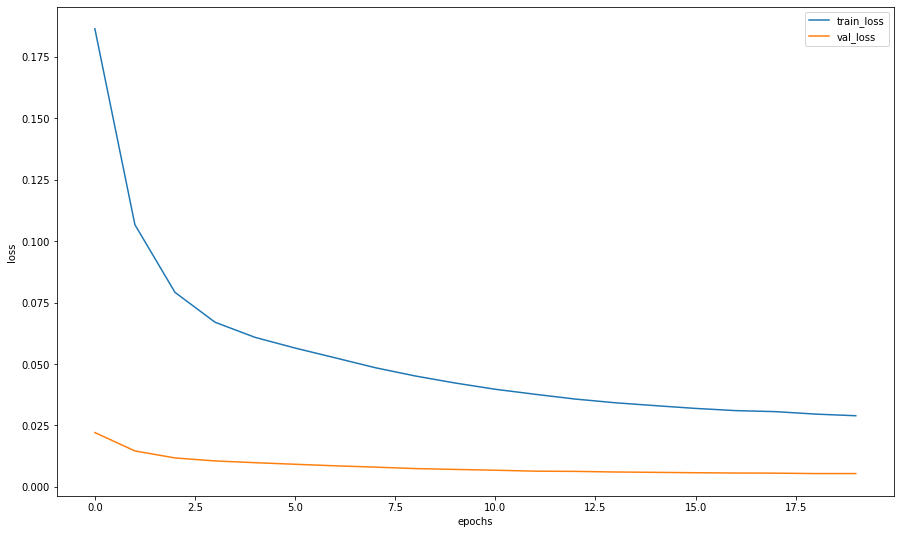

In [251]:
plt.figure(figsize=(15, 9))
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [252]:
train_losses[-1]

0.028922533616423607

In [253]:
val_losses[-1]

0.005393527448177338

Сравним произвольное изображение с ее реконструкцией

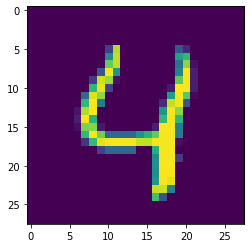

In [254]:
for item in testloader:
    x, y = item
    plt.imshow(x.view(-1,28,28)[4])
    break

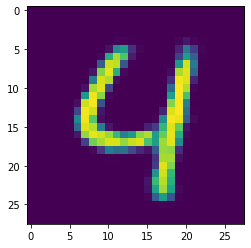

In [255]:
for item in testloader:
    autoencoder_conditional.eval()
    x, y = item
    result, latent_code_check = autoencoder_conditional(x.float(), y.float())
    
    reconstruction_check = result[:,:-10]

    plt.imshow(reconstruction_check.detach().view(-1,28,28)[4])
    break

## Sampling


In [0]:
#<тут нужно научиться сэмплировать из декодера цифры определенного класса>
desired_class = 1

In [0]:
# Найдем распределение латентных векторов ЖЕЛАЕМОГО КЛАССА
nur = latent_code_check

for item in trainloader:
    x, y = item
    if(x.shape[0] == 128):
        indeces = []
        for i in range(len(y)-1):
            if(y[i].numpy() == desired_class):
                indeces.append(i)             

        autoencoder_conditional.eval()
        reconstruction, latent_code = autoencoder_conditional(x[indeces].float(), y[indeces].float())

        nur = torch.cat([nur, latent_code], dim = 0)
        

In [0]:
nur = nur[129:,:]
mu = nur.mean(dim=0)
std = nur.std(dim=0)

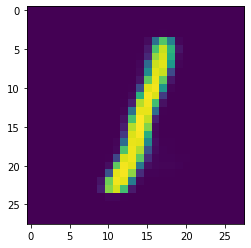

In [306]:
# сгенерируем рандомный вектор размера latent_space
z = std.detach().numpy()*np.random.randn(1, dimZ) + mu.detach().numpy()
z = torch.FloatTensor(z)
autoencoder_conditional.eval()
output = autoencoder_conditional.decoder(z, torch.FloatTensor([desired_class]))

output = output[:,:-10]
plt.imshow(output.detach().view(-1,28,28)[0])


Splendid! Вы великолепны!

Теперь давайте сделаем следующее: посмотрим на то, как выглядит латентное пространство векторов, соответствующих нашим картинкам. 
Для этого вам нужно:
1.  прогнать картинки из датасета через encoder, получить латентные векторы
2. Прогнать векторы через TSNE, получить их двумерную проекцию
3. Изобразить полученные после TSNE двумерные векторы на плоскости с помощью plt.scatter, покрасив точки в цвета в зависимости от класса картинки, которой она соответствует. (как красить точки, см. в документации к plt.scatter). 
4. Подумать, что вы видите и записать свои мысли

In [0]:
#<тут код получения латентных векторов, прогона через TSNE и рисования scatter plot>

<тут ваши мысли по поводу того, что вы видите на рисунке>

# BONUS 1. (2 балла) 
### Variational Autoencoder

Если вы (надеюсь) осознали, в каком месте у conditional AE выше могли бы быть проблемы, то -- тадам!!

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [0]:
class VAE(nn.Module):
    def __init__(self):
        #<определите архитектуры encoder и decoder
        #помните, у encoder должны быть два "хвоста", 
        #т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>

    def encode(self, x):
        #<реализуйте forward проход энкодера
        #в качестве ваозвращаемых переменных -- mu и logsigma>
        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            std = logsigma.exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z):
        #<реализуйте forward проход декодера
        #в качестве ваозвращаемой переменной -- reconstruction>
        
        return reconstruction

    def forward(self, x):
        #<используя encode и decode, реализуйте forward проход автоэнкодера
        #в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        return mu, logsigma, mu_z, reconstruction

Определим лосс и его компоненты для VAE:

In [0]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    return -(1/2) * (1 + 2*logsigma - mu**2 - torch.exp(logsigma)**2).sum(dim=-1)

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss()
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return -(-KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)).mean()

И обучим модель:

In [0]:
criterion = #<MSE LOSS>

autoencoder = Autoencoder()

optimizer = #<Ваш любимый оптимизатор>

In [0]:
<обучите модель, как и autoencoder>

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [0]:
< тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>

And finally sample from VAE.

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие лица получатся:

In [0]:
# вспомните про замечание из этого же ункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 100) for i in range(10)])
output = <скормите z декодеру>
plot_gallery(output.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=2, n_col=5)

## Congrats v2.0!

Как вы уже догадались, здесь тоже можно попробовать пририсовывать разные атрибуты людям. Можно, например, так же пририсовать улыбки и сравнить с тем, как это получалось у обычного автоэнкодера

In [0]:
<как вы уже догадались, тут Ваш код>

# BONUS 2. (2 балла)

А теперь пришло время сделать 
## Conditional Variational AE

In [0]:
<тут обучение Conditional Variational AE>

... и так же посмотреть на латентное пространство векторов VAE, как мы делали это с обычным variational AE, понять, чем же оно отличается и сделать выводы:

In [0]:
<тут код>

<тут выводы>

# BONUS 3. (2 балла)

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них это бонксное задание.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

Для того, чтобы поставить эксперимент, нужно взять ваш любимый датасет (датасет лиц или MSE с прошлых заданий или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [0]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

In [0]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [0]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# Bonus 4. (2+ балла)

Пишем телеграм-бота!

Можно написать телеграм-бота, которому на вход вы подаете, например, картинку без улыбки, а он вам возвращает с улыбкой.

Или еще много вариантов, чего может уметь делать бот. Придумайте сами)

# Эпилог

здесь мы рассмотрели не все применения автоэнкодеров. Еще есть, например:

-- поиск аномалий
-- дополнение отсутствующих частей картины
-- работа с sequential данными (например, временными рядами)
-- гибриды ГАН+АЕ, которые активно изучаются в последнее время
-- использование латентных переменных АЕ в качестве фичей
...

Они не были частью этого проекта, потому что для их реализации пришлось бы больше возиться с датасетами. 

Но! Если вы хотите, вы, конечно, всегда можете реализовать еще что-то и получить за это еще допбаллы.

Надеюсь, вам понравилось!